# MICs 3T micapipe v0.2.0

In [1]:
# Set the environment
import os
import numpy as np
import matplotlib as plt
import nibabel as nb
from nibabel.freesurfer.mghformat import load
from brainspace.plotting import plot_hemispheres
from brainspace.mesh.mesh_io import read_surface
from brainspace.datasets import load_conte69
from brainspace.datasets.base import load_mask
from brainspace.gradient import GradientMaps
from brainspace.utils.parcellation import map_to_labels
from brainspace.mesh.array_operations import smooth_array
import seaborn as sns
import matplotlib.pyplot as mpl

# Set the working directory to the 'out' directory
os.chdir("/data_/mica3/BIDS_MICs/") 

# This variable will be different for each subject
micapipe='/data_/mica1/01_programs/micapipe-v0.2.0'
derivatives='/data_/mica3/BIDS_MICs/derivatives'
out=derivatives+ '/micapipe_v0.2.0/'
sub='sub-HC062'
subjectID=sub+'_ses-01'
subjectDir=out + sub+'/ses-01'
recon='freesurfer'

# Set paths and variables
dir_FS = derivatives+'/'+recon+'/' + subjectID

# Load native pial surface
def load_surf(label='pial', surf='fsnative'):
    gm_lh = read_surface(subjectDir+'/surf/'+subjectID+'_hemi-L_space-nativepro_surf-'+surf+'_label-'+label+'.surf.gii', itype='gii')
    gm_rh = read_surface(subjectDir+'/surf/'+subjectID+'_hemi-R_space-nativepro_surf-'+surf+'_label-'+label+'.surf.gii', itype='gii')
    return (gm_lh, gm_rh)

def load_feat(label='thickness', surf='fsnative'):
    dat_lh = nb.load(subjectDir+'/maps/'+subjectID+'_hemi-L_surf-'+surf+'_label-'+label+'.func.gii').darrays[0].data
    dat_rh = nb.load(subjectDir+'/maps/'+subjectID+'_hemi-R_surf-'+surf+'_label-'+label+'.func.gii').darrays[0].data
    dat = np.concatenate((dat_lh, dat_rh), axis=0)
    return (dat)

def plot_connectome(mtx, Title='matrix plot', xlab='X', ylab='Y', col='rocket', Vmin=None, Vmax=None):
    '''
    This optional function, only plots a connectome as a heatmap
    Parameters
    ----------
    mtx : np.array
    Returns
    -------
    f : plot
    '''
    f, ax = mpl.subplots(figsize=(15,10))
    g = sns.heatmap(mtx, ax=ax, cmap=col, vmin=Vmin, vmax=Vmax)
    g.set_xlabel(xlab)
    g.set_ylabel(ylab)
    g.set_title(Title)

# Colormap
ColCurv= plt.colors.ListedColormap(['#A2CD5A', '#A0CA5B', '#9FC85C', '#9EC55D', '#9DC35E', '#9CC05F', '#9BBE61', '#9ABB62', '#99B963', '#98B664', '#96B465', '#95B166', '#94AF68', '#93AC69', '#92AA6A', '#91A76B', '#90A56C', '#8FA26D', '#8EA06F', '#8C9D70', '#8B9B71', '#8A9972', '#899673', '#889475', '#879176', '#868F77', '#858C78', '#848A79', '#82877A', '#81857C', '#80827D', '#7F807E', '#807D7D', '#827A7A', '#857777', '#877575', '#8A7272', '#8C6F6F', '#8F6C6C', '#916969', '#946666', '#966464', '#996161', '#9B5E5E', '#9D5B5B', '#A05858', '#A25656', '#A55353', '#A75050', '#AA4D4D', '#AC4A4A', '#AF4747', '#B14545', '#B44242', '#B63F3F', '#B93C3C', '#BB3939', '#BE3636', '#C03434', '#C33131', '#C52E2E', '#C82B2B', '#CA2828', '#CD2626'])
grey = plt.colors.ListedColormap(np.full((256, 4), [0.65, 0.65, 0.65, 1]))

from brainspace.datasets import load_parcellation
labeling = load_parcellation('schaefer', scale=400, join=True)
mask = labeling != 0

# Load Canonical surfaces
# inflated native
# Load native inflated surface
inf_lh = read_surface(dir_FS+'/surf/lh.inflated', itype='fs')
inf_rh = read_surface(dir_FS+'/surf/rh.inflated', itype='fs')

# fsaverage5
fs5_lh = read_surface(derivatives+'/freesurfer/fsaverage5/surf/lh.pial', itype='fs')
fs5_rh = read_surface(derivatives+'/freesurfer/fsaverage5/surf/rh.pial', itype='fs')
fs5_lhi = read_surface(derivatives+'/freesurfer/fsaverage5/surf/lh.inflated', itype='fs')
fs5_rhi = read_surface(derivatives+'/freesurfer/fsaverage5/surf/rh.inflated', itype='fs')

# fsLR-32k
c69_lh = read_surface(micapipe + '/surfaces/fsLR-32k.L.surf.gii', itype='gii')
c69_rh = read_surface(micapipe + '/surfaces/fsLR-32k.R.surf.gii', itype='gii')
c69_lhi = read_surface(micapipe + '/surfaces/fsLR-32k.L.inflated.surf.gii', itype='gii')
c69_rhi = read_surface(micapipe + '/surfaces/fsLR-32k.R.inflated.surf.gii', itype='gii')

# fsLR-5k
# Canonical surface
c5k_lh = read_surface('/data_/mica3/BIDS_MICs/fsLR_5k/surface/deformed_fsLR_5k.L.surf.gii', itype='gii')
c5k_rh = read_surface('/data_/mica3/BIDS_MICs/fsLR_5k/surface/deformed_fsLR_5k.R.surf.gii', itype='gii')

c5kr_lh = read_surface('/data_/mica3/BIDS_MICs/fsLR_5k/surface/fsLR_5k-regular.L.surf.gii', itype='gii')
c5kr_rh = read_surface('/data_/mica3/BIDS_MICs/fsLR_5k/surface/fsLR_5k-regular.R.surf.gii', itype='gii')

c5kd_lh = read_surface('/data_/mica3/BIDS_MICs/fsLR_5k/surface/deformed_fsLR_5k.L.sphere.surf.gii', itype='gii')
c5kd_rh = read_surface('/data_/mica3/BIDS_MICs/fsLR_5k/surface/deformed_fsLR_5k.R.sphere.surf.gii', itype='gii')


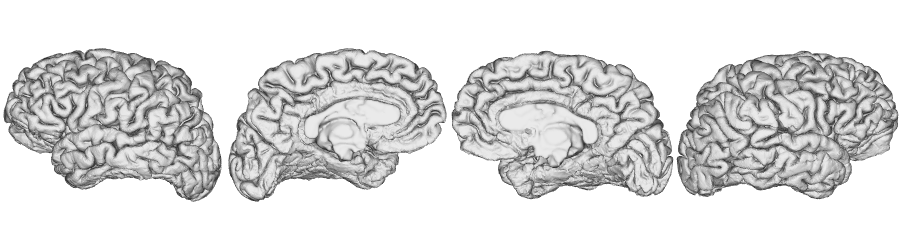

In [2]:
# Plot the surface
gm_lh, gm_rh = load_surf(label='pial', surf='fsnative')
plot_hemispheres(gm_lh, gm_rh, size=(900, 250), zoom=1.25, embed_nb=True, interactive=False, share='both',
                 nan_color=(0, 0, 0, 1), color_range=(1.5, 4), cmap=grey, transparent_bg=False)

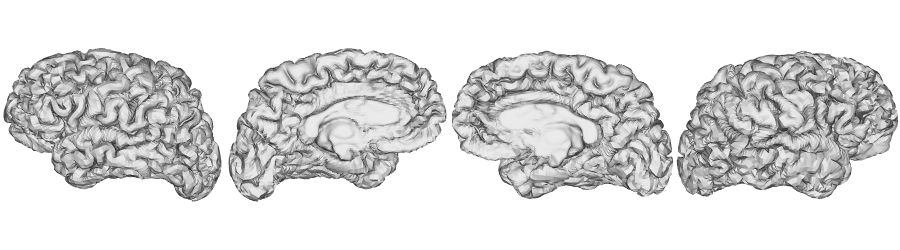

In [3]:
# Plot the surface
gm_lh, gm_rh = load_surf(label='pial', surf='fsLR-32k')
plot_hemispheres(gm_lh, gm_rh, size=(900, 250), zoom=1.25, embed_nb=True, interactive=False, share='both',
                 nan_color=(0, 0, 0, 1), color_range=(1.5, 4), cmap=grey, transparent_bg=False)

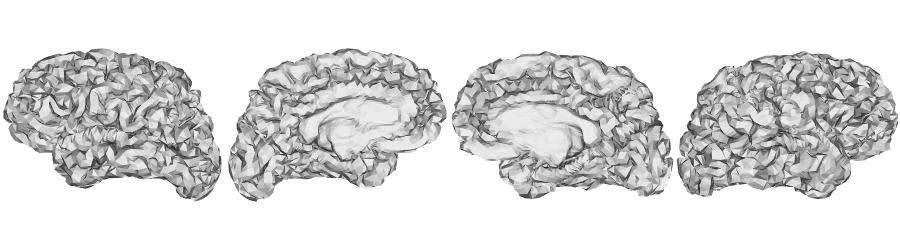

In [4]:
# Plot the surface
gm_lh, gm_rh = load_surf(label='pial', surf='fsaverage5')
plot_hemispheres(gm_lh, gm_rh, size=(900, 250), zoom=1.25, embed_nb=True, interactive=False, share='both',
                 nan_color=(0, 0, 0, 1), color_range=(1.5, 4), cmap=grey, transparent_bg=False)

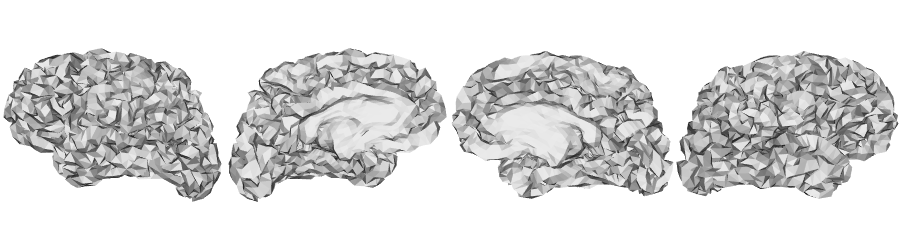

In [5]:
# Plot the surface
gm_lh, gm_rh = load_surf(label='pial', surf='fsLR-5k')
plot_hemispheres(gm_lh, gm_rh, size=(900, 250), zoom=1.25, embed_nb=True, interactive=False, share='both',
                 nan_color=(0, 0, 0, 1), color_range=(1.5, 4), cmap=grey, transparent_bg=False)

# Thickness: fsnative
Note: `fsnative` is not smoothed 10mm

(471470,)


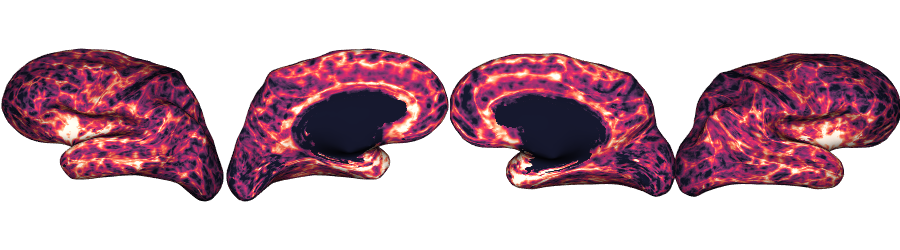

In [6]:
# Plot the surface
feat = load_feat(label='thickness', surf='fsnative')
plot_hemispheres(inf_lh, inf_rh,array_name=feat, size=(900, 250), zoom=1.25, embed_nb=True, interactive=False, share='both',
                 nan_color=(0, 0, 0, 1), color_range=(1.5, 4), cmap='rocket', transparent_bg=False)

(20484,)


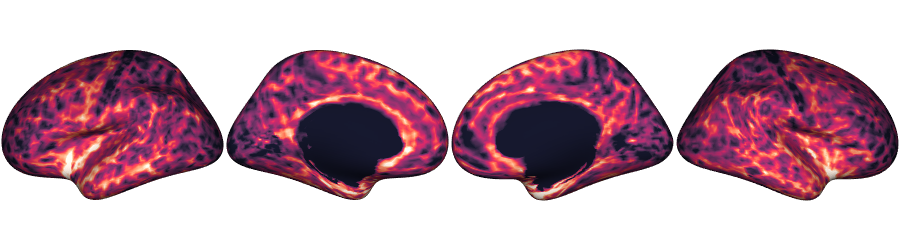

In [7]:
# Plot the surface
feat = load_feat(label='thickness', surf='fsaverage5')
print(feat.shape)
gm_lh, gm_rh = load_surf(label='pial', surf='fsaverage5')
plot_hemispheres(fs5_lhi, fs5_rhi,array_name=feat, size=(900, 250), zoom=1.25, embed_nb=True, interactive=False, share='both',
                 nan_color=(0, 0, 0, 1), color_range=(1.5, 4), cmap='rocket', transparent_bg=False)

(64984,)


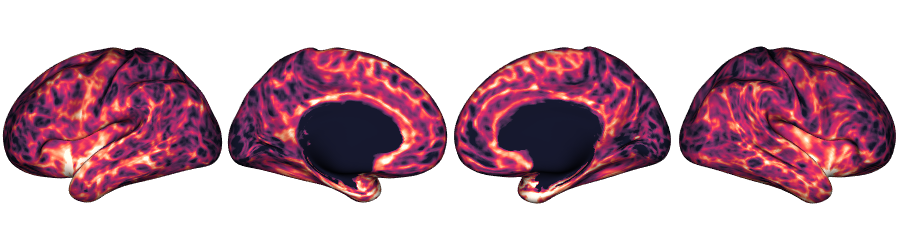

In [8]:
# Plot the surface
feat = load_feat(label='thickness', surf='fsLR-32k')
gm_lh, gm_rh = load_surf(label='pial', surf='fsLR-32k')
print(feat.shape)
plot_hemispheres(c69_lhi, c69_rhi,array_name=feat, size=(900, 250), zoom=1.25, embed_nb=True, interactive=False, share='both',
                 nan_color=(0, 0, 0, 1), color_range=(1.5, 4), cmap='rocket', transparent_bg=False)

(9684,)


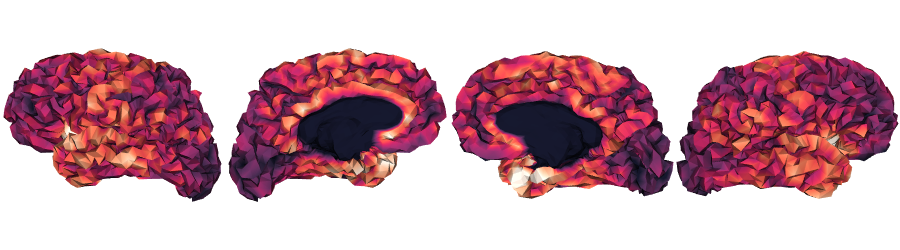

In [9]:
# Plot the surface
feat = load_feat(label='thickness', surf='fsLR-5k')
print(feat.shape)
gm_lh, gm_rh = load_surf(label='pial', surf='fsLR-5k')
plot_hemispheres(gm_lh, gm_rh,array_name=feat, size=(900, 250), zoom=1.25, embed_nb=True, interactive=False, share='both',
                 nan_color=(0, 0, 0, 1), color_range=(1.5, 4), cmap='rocket', transparent_bg=False)

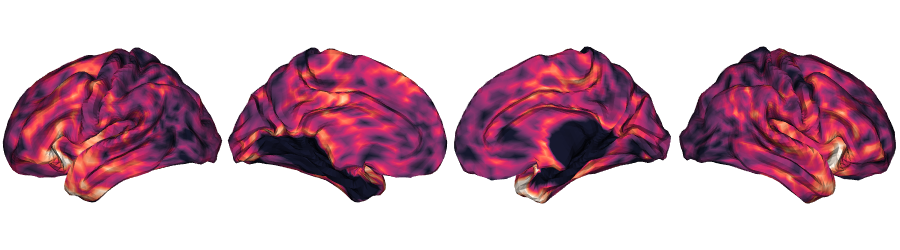

In [10]:
# Plot the surface
plot_hemispheres(c5k_lh, c5k_rh,array_name=feat, size=(900, 250), zoom=1.25, embed_nb=True, interactive=False, share='both',
                 nan_color=(0, 0, 0, 1), color_range=(1.5, 4), cmap='rocket', transparent_bg=False)

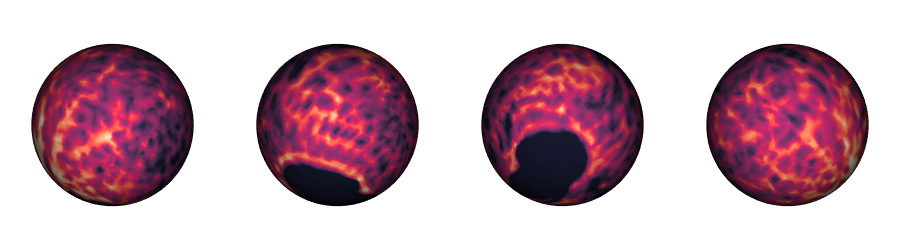

In [11]:
# Plot the surface
plot_hemispheres(c5kd_lh, c5kd_rh,array_name=feat, size=(900, 250), zoom=1.25, embed_nb=True, interactive=False, share='both',
                 nan_color=(0, 0, 0, 1), color_range=(1.5, 4), cmap='rocket', transparent_bg=False)

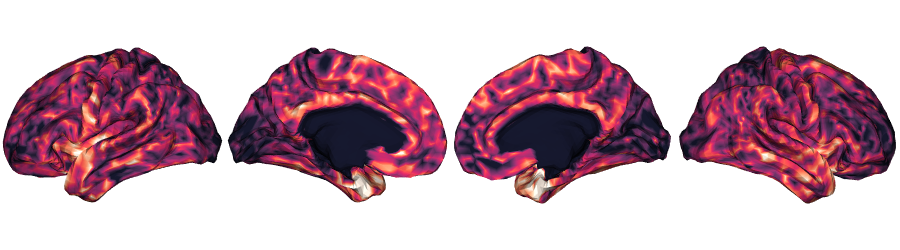

In [12]:
dat_lh = nb.load('/data_/mica3/BIDS_MICs/fsLR_5k/surface/test/sub-HC007_fsLR_5k_lh_thickness.func.gii').darrays[0].data
dat_rh = nb.load('/data_/mica3/BIDS_MICs/fsLR_5k/surface/test/sub-HC007_fsLR_5k_rh_thickness.func.gii').darrays[0].data
dat = np.concatenate((dat_lh, dat_rh), axis=0)

plot_hemispheres(c5kr_lh, c5kr_rh,array_name=dat, size=(900, 250), zoom=1.25, embed_nb=True, interactive=False, share='both',
                 nan_color=(0, 0, 0, 1), color_range=(1.5, 4), cmap='rocket', transparent_bg=False)

# Curvature

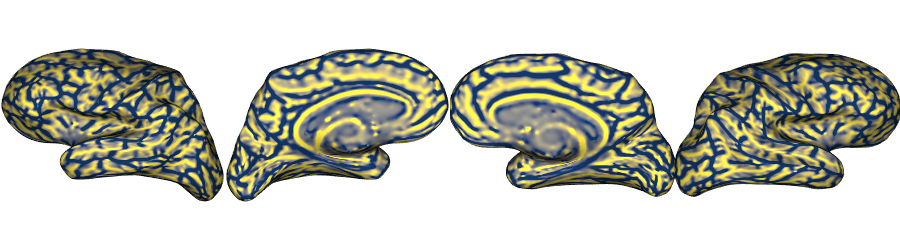

In [18]:
# Plot the surface
feat = load_feat(label='curv', surf='fsnative')
plot_hemispheres(inf_lh, inf_rh,array_name=feat, size=(900, 250), zoom=1.25, embed_nb=True, interactive=False, share='both',
                 nan_color=(0, 0, 0, 1), color_range=(-0.2, 0.2), cmap='cividis', transparent_bg=False)

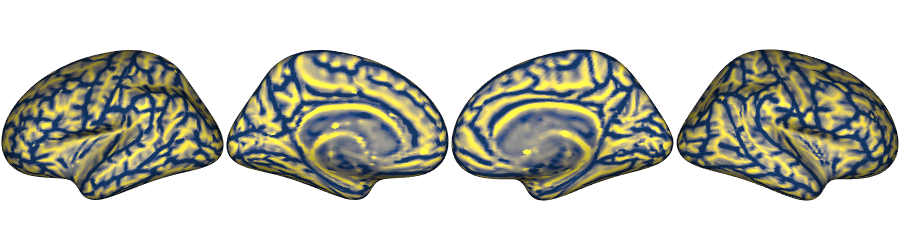

In [21]:
# Plot the surface
feat = load_feat(label='curv', surf='fsaverage5')
gm_lh, gm_rh = load_surf(label='pial', surf='fsaverage5')
plot_hemispheres(fs5_lhi, fs5_rhi,array_name=feat, size=(900, 250), zoom=1.25, embed_nb=True, interactive=False, share='both',
                 nan_color=(0, 0, 0, 1), color_range=(-0.2,0.2), cmap='cividis', transparent_bg=False)

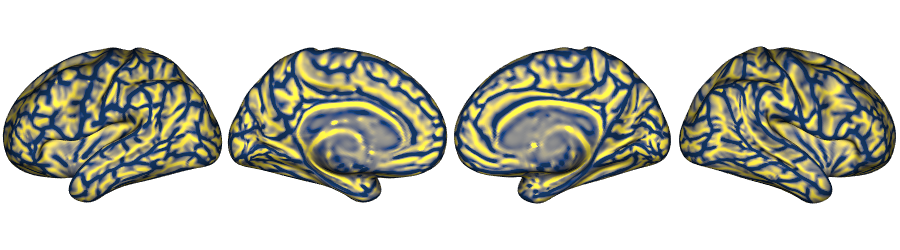

In [22]:
# Plot the surface
feat = load_feat(label='curv', surf='fsLR-32k')
gm_lh, gm_rh = load_surf(label='pial', surf='fsLR-32k')
plot_hemispheres(c69_lhi, c69_rhi,array_name=feat, size=(900, 250), zoom=1.25, embed_nb=True, interactive=False, share='both',
                 nan_color=(0, 0, 0, 1), color_range=(-0.2,0.2), cmap='cividis', transparent_bg=False)

(9684,)


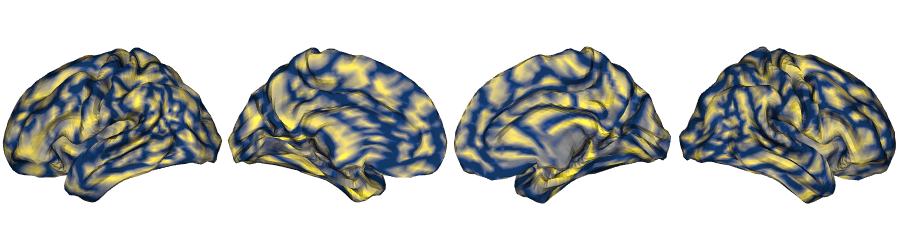

In [100]:
# Plot the surface
feat = load_feat(label='curv', surf='fsLR-5k')
print(feat.shape)
gm_lh, gm_rh = load_surf(label='pial', surf='fsLR-5k')
plot_hemispheres(c5k_lh, c5k_rh,array_name=feat, size=(900, 250), zoom=1.25, embed_nb=True, interactive=False, share='both',
                 nan_color=(0, 0, 0, 1), color_range=(-0.2, 0.2), cmap='cividis', transparent_bg=False)